# <font style="color:blue">Project 4: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://github.com/ishann/aeroscapes/blob/master/assets/data_montage.png?raw=true" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import math
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import albumentations as A



In [3]:
class SemSegDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, transforms = None, train:bool = True):
        self.root = root
        self.transforms = transforms
        self.train = train
        self.csv_file = os.path.join(root,'train.csv')
        self.file = pd.read_csv(self.csv_file)
                
        train_imgs, test_imgs = train_test_split(self.file['ImageID'].tolist(), shuffle=False,test_size=0.2, random_state=47)
        
        if train:
            self.images_path = train_imgs
        else:
            self.images_path = test_imgs
        
        self.imgs_dir = os.path.join(root, 'imgs','imgs')
        self.masks_dir = os.path.join(root, 'masks','masks')
        
    
    def __len__(self):
        return len(self.images_path)
        
    def __getitem__(self, idx):
        
        image_file = self.images_path[idx]
        image_path = os.path.join(self.imgs_dir, str(image_file)+'.jpg')
        mask_path = os.path.join(self.masks_dir, str(image_file)+'.png')
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            # tranformed  = self.transforms(image = image, mask=mask)
            # image = transformed['image']
            # mask = transformed['masks']
            image = self.transforms(image)
            mask = self.transforms(mask)
                                          
        return image, mask
        
        
        
       
            

In [4]:
a = SemSegDataset('opencv-pytorch-course-segmentation')

In [5]:
len(a.file['ImageID'].tolist())

2621

In [6]:
aa, bb = train_test_split(a.file['ImageID'].tolist(), shuffle=False,test_size=0.2, random_state=47)

print(len(aa), aa[0])
print(len(bb), bb[0])

2096 6119677716839104391
525 2584699245745252636


## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

**In this sub-section,  you have to plot a few images and its mask.**

**for example:**

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-data-sample.png">

---

In [7]:
# Define the helper function
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
    # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
    (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
    # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
    (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
    # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
    # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    
    return rgb

(720, 1280, 3) (720, 1280)
(720, 1280, 3)
(720, 1280, 3) (720, 1280)
(720, 1280, 3)
(720, 1280, 3) (720, 1280)
(720, 1280, 3)


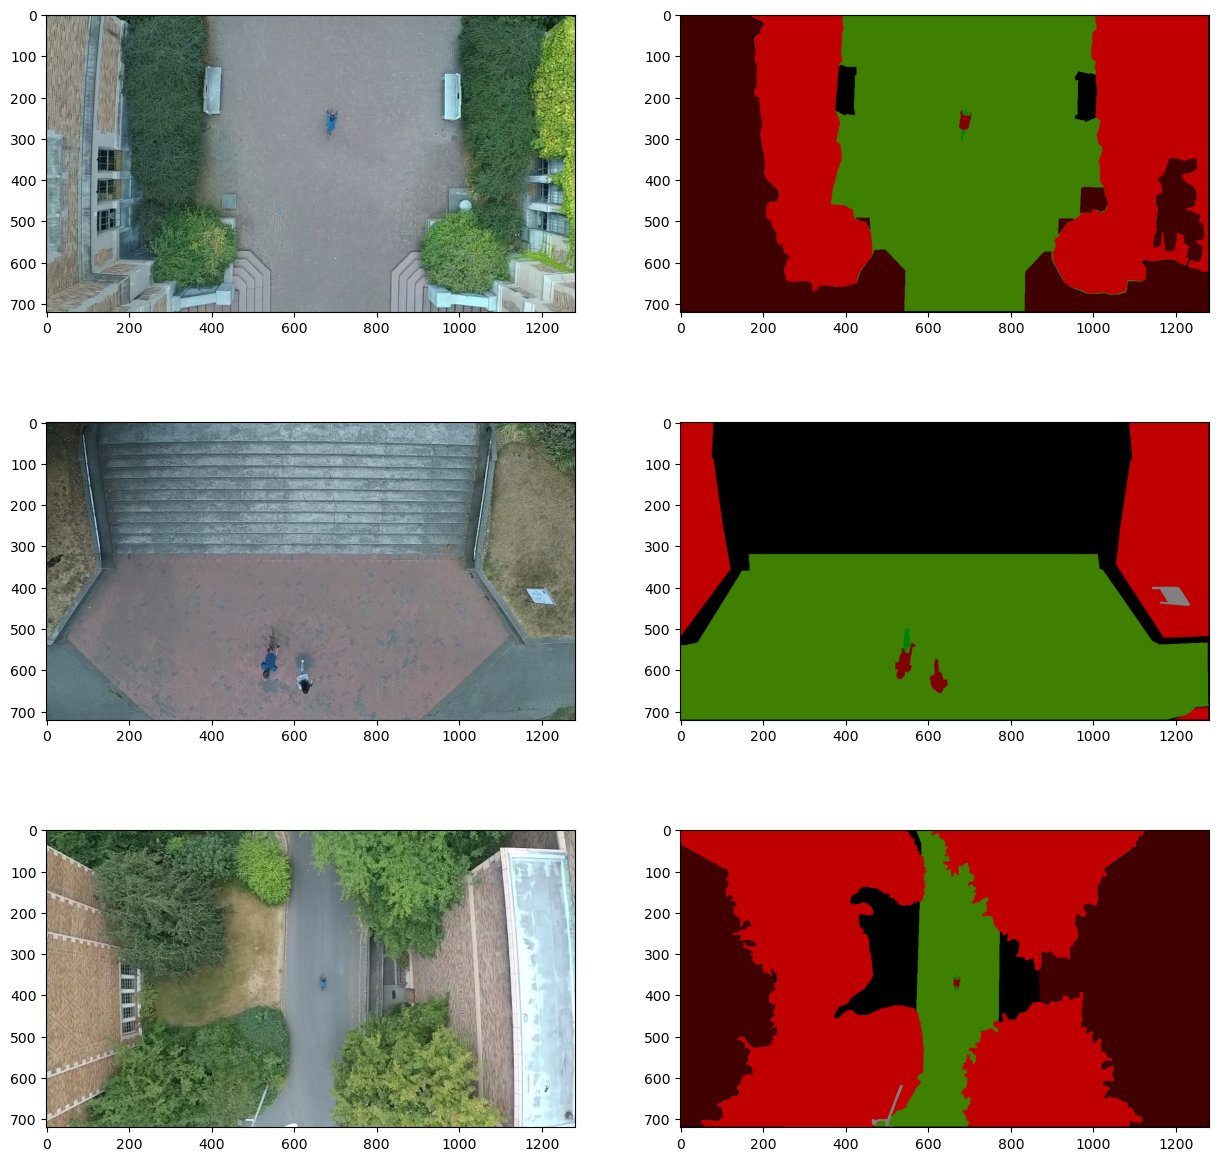

In [8]:

a = SemSegDataset('opencv-pytorch-course-segmentation')

#fig, axs = plt.subplots(3, 2)
fig = plt.figure(figsize=(15, 15)) 
rows = 3
columns = 2
index = 1

for i in range(3):
    image, mask = a.__getitem__(index)
    print(image.shape, mask.shape)
    
    
    fig.add_subplot(rows, columns, index)        
    plt.imshow(image)
    index += 1
    
    fig.add_subplot(rows, columns, index)       
    mask_rgb = decode_segmap(mask, 13)
    print(mask_rgb.shape)
    plt.imshow(mask_rgb)
    index += 1
        

# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

In [9]:
def dice_coefficient_multiclass(mask1, mask2, num_classes=12):
    dice_coefficients = []

    for class_label in range(num_classes):
        # Criar máscaras binárias para a classe atual
        bin_mask1 = (mask1 == class_label).astype(bool)
        bin_mask2 = (mask2 == class_label).astype(bool)
        
        if np.sum(bin_mask1)==0 and np.sum(bin_mask2)==0:
            dice_coefficients.append(1)
            continue

        # Calcular a interseção e a união para a classe atual
        intersection = np.logical_and(bin_mask1, bin_mask2)
        union = np.logical_or(bin_mask1, bin_mask2)
        
        # Calcular o Coeficiente de Dice para a classe atual
        dice_class = (2.0 * np.sum(intersection)) / (np.sum(bin_mask1) + np.sum(bin_mask2))
        dice_coefficients.append(dice_class)

    return np.mean(dice_coefficients), dice_coefficients

In [10]:
image, mask = a.__getitem__(0)
image2, mask2 = a.__getitem__(1)

In [11]:
dice_coefficient_multiclass(mask, mask, 12)

(1.0, [1.0, 1.0, 1.0, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1])

In [12]:
dice_coefficient_multiclass(mask, mask2, 12)

(0.6169176408343139,
 [0.0,
  0.0,
  0.0,
  1,
  1,
  1,
  1,
  1,
  0.0,
  0.5789764904198783,
  0.8240351995918888,
  1])

# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

In [13]:

# Definir a arquitetura do modelo de segmentação (U-Net simples)
class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleUNet, self).__init__()
        # Definir a arquitetura do U-Net (pode ser mais complexa dependendo do problema)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
import torch.nn as nn

class ComplexUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ComplexUNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0, output_padding=0),  # Ajuste do stride e padding
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, out_channels, kernel_size=2, stride=2, padding=0, output_padding=0),  # Ajuste do stride e padding
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [30]:
def mask_to_onehot(masks, num_classes=12):
    masks = masks.type(torch.int)
    
    # Criar um conjunto de canais identidade para cada classe
    identity_channels = torch.eye(num_classes, dtype=torch.int)
    
    # Indexar os canais com as máscaras para obter a representação one-hot
    one_hot_representation = identity_channels[masks]
    
    return one_hot_representation


# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**



## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validatin data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---


In [16]:
# Definir transformações para os dados (ajuste conforme necessário)
transforms_train = transforms.Compose([
    transforms.ToTensor(),
    # Adicionar outras transformações conforme necessário
])

In [17]:
val_dataset = SemSegDataset('opencv-pytorch-course-segmentation', transforms=transforms_train, train=False)
train_dataset = SemSegDataset('opencv-pytorch-course-segmentation', transforms=transforms_train, train=True)

In [18]:
train_dataloader = DataLoader(train_dataset, 8, True)
val_dataloader = DataLoader(val_dataset, 8, False)

In [19]:
# Inicializar o modelo
in_channels = 3  # Número de canais da imagem (RGB)
out_channels = 12  # Número de classes 
model = ComplexUNet(in_channels, out_channels)

In [20]:
# Definir a função de perda (CrossEntropyLoss é comumente usada para segmentação)
criterion = nn.CrossEntropyLoss()
# Definir otimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Número de épocas
num_epochs = 10

In [31]:
best_loss = 100000

train_loss_list =[]
val_loss_list =[]

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        optimizer.zero_grad()

        # Passagem para a frente
        outputs = model(images)
        masks_onehot = mask_to_onehot(masks)
        # Calcular a perda
        loss = criterion(outputs, masks_onehot)

        # Passagem para trás e otimização
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calcular a média da perda para a época
    avg_loss = total_loss / len(train_dataloader)
    train_loss_list.append(avg_loss)
    print(f'Treino - Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}')

    # Avaliação no conjunto de validação
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images_val, masks_val in tqdm(val_dataloader, desc=f'Validation {epoch+1}/{num_epochs}'):
            outputs_val = model(images_val)
            loss_val = criterion(outputs_val, masks_val)
            total_val_loss += loss_val.item()
            val_loss_list.append(total_val_loss)
        
        avg_val_loss = total_val_loss / len(val_loader)
        print(f'Validação - Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_val_loss}')
        if best_loss > avg_val_loss:
            torch.save(model.state_dict(), 'best_loss.pth')
            best_loss = avg_val_loss
            print('--> New Best \n')


    
# Salvar o modelo treinado se necessário
torch.save(model.state_dict(), 'last_model.pth')

Epoch 1/10:   0%|                                                                              | 0/262 [00:00<?, ?it/s]

outputs torch.Size([8, 12, 720, 1280])
masks torch.Size([8, 1, 720, 1280])


Epoch 1/10:   0%|                                                                              | 0/262 [05:05<?, ?it/s]

masks_onehot torch.Size([8, 1, 720, 1280, 12])


NameError: name 'train_loader' is not defined

## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---



# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

In [ ]:
import numpy as np

# Suponha que 'batch_mask' seja seu batch de máscaras numpy de um canal
batch_mask = np.array([[[0, 1, 2],
                       [2, 0, 1],
                       [1, 2, 0]],
                      
                      [[2, 1, 0],
                       [0, 2, 1],
                       [1, 0, 2]]])

# Adicionar a dimensão do canal (1) à entrada
batch_mask = np.expand_dims(batch_mask, axis=1)

# Obter o número de amostras, número de classes, largura e altura
n, _, w, h = batch_mask.shape
num_classes = np.max(batch_mask) + 1

# Criar um conjunto de canais identidade para cada classe
identity_channels = np.eye(num_classes)

# Indexar os canais com o batch de máscaras para obter a representação one-hot
one_hot_representation = identity_channels[batch_mask.squeeze(axis=1)]

# Exemplo de saída
print(one_hot_representation)


In [ ]:
batch_mask.shape

In [ ]:
one_hot_representation.shape

# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum IoU of `0.60` on the test data to get all points. If the IoU is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**